In order to determine how the data should be processed we did some testing

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix

import numpy as np


Duplicates were removed. Each feature was plotted as a histogram to get an overview of the data.

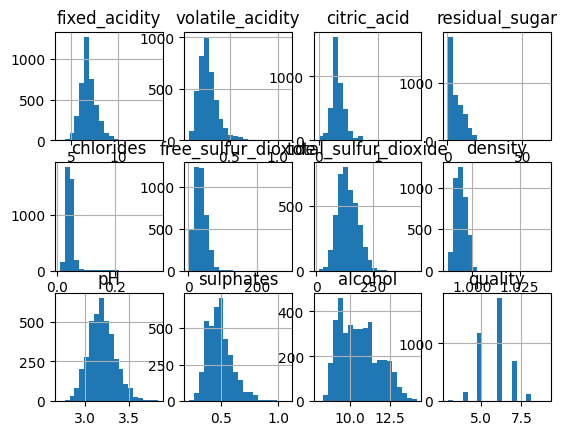

In [2]:
wine_quality = pd.read_csv("./winequality/winequality-white.csv", sep=";")
df_features = wine_quality
df_features.drop_duplicates(inplace = True)

def visualize_dataset(data, columns):
    fig, axis = plt.subplots(3, 4)
    c = 0
    for i in range(3):
        for j in range(4):
            if c == 11:
                break
            axis[i,j].title.set_text(columns[c])
            data[columns[c]].hist(bins = 20, ax = axis[i,j])
            c += 1
    axis[2,3].title.set_text("quality")
    data["quality"].hist(bins = 20, ax = axis[2,3])
    plt.show()

columns = wine_quality.columns
visualize_dataset(wine_quality, columns)

Looking at the distribution of different qualitites, we decided to formulate a classification problem with three classes; "poor", "average" and "good" quality wines.  We decided that any wine with a quality greader than six is good, any whine with a quality less tha six is poor and any wine with a quality at six is average. This gave us a dataset with a bit of imbalance but not too bad.

In [3]:
X, y = df_features.iloc[:,:-1], df_features.iloc[:,-1:]

v = y.values.squeeze()
v1 = np.select([v<6,v==6, v>6],[0,1,2])[:,None]
y = pd.DataFrame(v1, columns=["quality"])

Since the application requires manual input for each feature we decided to only handle features that have highest predictive power. We also tried to avoid having multiple features that measure essentially the same thing. After some testing we found that a random forest classifiers gave the best results. It also means that we don't need to perform any rescaling of the data. We used this in order to determine the most important features. The importace of the features was measured using permutation importance which measures importance of features by shuffling their values and measuring the impact this has on the performance. The most important features will lead to a larger impact and vice versa.

C:\Users\willi\AppData\Local\Temp\ipykernel_23668\3866069134.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


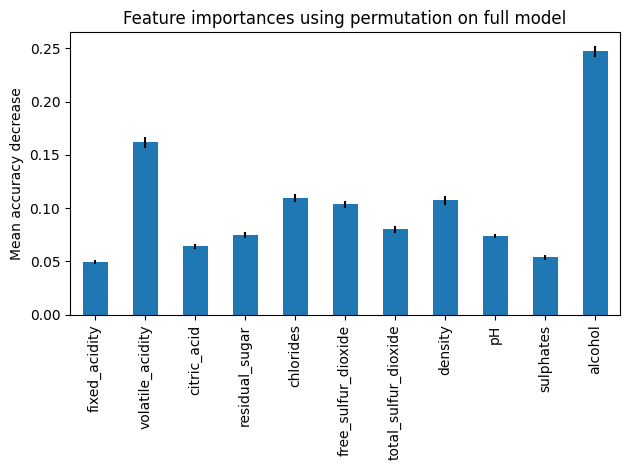

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=100)
clf = RandomForestClassifier(n_estimators=1000, max_depth=12)
clf.fit(X_train, y_train)
result = permutation_importance(clf, X_train, y_train, n_repeats=20,random_state=0, n_jobs=-1)
#print(result.importances_mean)
forest_importances = pd.Series(result.importances_mean, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Looking at the plot above we decided to include, alcohol, volatile_acidity, chlorines, free_sulfur_dioxide and residual_sugar. Our thought process was that we wanted the most important features but if two features essentially measure the same thing we take the most important one. For example different features are connected to acidity. We then measured the performance impact of omitting the features we deemed less important.

In [5]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=12)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
scores = cross_val_score(clf, X=X, y=y.values.ravel(), cv = cv, n_jobs=-1)
print("Accuracy mean:",scores.mean(), "std:",scores.std())

clf = RandomForestClassifier(n_estimators=1000, max_depth=12)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(confusion_matrix(y_test, predicted))

Accuracy mean: 0.6143282107387901 std: 0.025135831238694548


C:\Users\willi\AppData\Local\Temp\ipykernel_23668\1320468305.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


[[ 94  35   6]
 [ 50 118  11]
 [  4  42  37]]


In [6]:
df_features = wine_quality

drop_col = ["fixed_acidity",
           "citric_acid",
           "total_sulfur_dioxide",
           "density",
           "pH",
           "sulphates",
           ]

df_features.drop(columns = drop_col, inplace = True)
df_features.drop_duplicates(inplace = True)

In [7]:
X, y = df_features.iloc[:,:-1], df_features.iloc[:,-1:]

v = y.values.squeeze()
v1 = np.select([v<6,v==6, v>6],[0,1,2])[:,None]
y = pd.DataFrame(v1, columns=["quality"])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
clf = RandomForestClassifier(n_estimators=1000, max_depth=12)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
scores = cross_val_score(clf, X=X, y=y.values.ravel(), cv = cv, n_jobs=-1)
print("Accuracy mean:",scores.mean(), "std:",scores.std())

clf = RandomForestClassifier(n_estimators=1000, max_depth=12)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(confusion_matrix(y_test, predicted))

Accuracy mean: 0.59527324627685 std: 0.017427609725743108


C:\Users\willi\AppData\Local\Temp\ipykernel_23668\438785120.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


[[ 76  54   4]
 [ 38 120  20]
 [  3  44  35]]


Dropping features predictably lead to a decrease in performance but it was not massive which meant that the features we picked was fine for the app.

In order to balance the classes better we also chose to do oversampling using SMOTE. In our opinion each class is of simila interest and one should therefore expect similar accuracy on each class individually. However the accuracy became a bit worse as we trade precision for better recall.

In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score


sm = SMOTE(sampling_strategy={0:1205,1:1599,2:1500})

print(np.unique(y_train, return_counts=True))
X_train, y_train = sm.fit_resample(X_train, y_train)
print(np.unique(y_train, return_counts=True))

clf = RandomForestClassifier(n_estimators=1000, max_depth=12)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

accuracy = accuracy_score(y_test, predicted)
print(confusion_matrix(y_test, predicted))
print(accuracy)

(array([0, 1, 2]), array([1205, 1599,  738], dtype=int64))
(array([0, 1, 2]), array([1205, 1599, 1500], dtype=int64))


C:\Users\willi\AppData\Local\Temp\ipykernel_23668\3233634022.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


[[78 42 14]
 [38 87 53]
 [ 3 25 54]]
0.5558375634517766
